In [1]:
import numpy as np
from PIL import Image
import pandas as pd
%config Completer.use_jedi = False

# Building the DataFrame

In [36]:
image_names = !ls ../raw_data/images_test_rev1/ #loading images_names.jpg to list
df_image_names = pd.DataFrame(image_names)  
df_image_names = df_image_names.rename(columns={0:'image'}) 
df_training_solutions_rev1 = pd.read_csv('../raw_data/training_solutions_rev1.csv')
#loading y dataframe

In [3]:
df_training_solutions_rev1['image'] = df_image_names['image']
df_X_y = df_training_solutions_rev1.drop(columns=['GalaxyID'])
df_X_y.head(2) #final dataframe with y and image_names.jpg

,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,...,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6,image
0,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,...,0.279952,0.138445,0.00000,0.0,0.092886,0.0,0.0,0.0,0.325512,100018.jpg
1,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,...,0.000000,0.131378,0.45995,0.0,0.591328,0.0,0.0,0.0,0.000000,100037.jpg


In [4]:
df_X_y_sample = df_X_y.sample(400)
df_X_y_sample.shape

(400, 38)

In [40]:
df_X_y_train = df_X_y_sample[:200]
df_X_y_test = df_X_y_sample[200:]
df_X_y_train.shape


(200, 38)

In [6]:
import tensorflow as tf

def load_image(image):
    '''returns one image'''
    folder = f'../raw_data/images_test_rev1/{image}'
    img = Image.open(folder)
    img_array = np.array(img)
    return np.resize(img_array, (224,224,3))
    
def load_images(df):
    '''returns array of images'''
    img_list = []
    for _, row in df.iterrows():
        img = load_image(row["image"])
        img_list.append(img) 
    return np.stack(img_list)

class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, df, batch_size=64, shuffle=True, ):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.on_epoch_end()
        

    def __len__(self):
        '''returns number of minibatches per epoch'''
        return len(self.indices) // self.batch_size
    
    def on_epoch_end(self):
        '''shuffles the indices '''
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)
            
    def __get_X_image(self, df):
        '''returns images'''
        X = load_images(df)
        return X 
             
    def __get_Y(self, df):
        '''returns y'''
        return np.array(df.drop(columns=["image"]))
    
    def _get_data(self, batch):
        '''returns batch of images and y'''
        df_batch = self.df.query("index in @batch") 
        X = self.__get_X_image(df_batch)
        y = self.__get_Y(df_batch)
        return X, y
    
    def __getitem__(self, index):
        '''creates batches and returns final X and y'''
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        X, y = self._get_data(batch)
        return X, y

In [7]:
datagenerator_train = DataGenerator(df=df_X_y_train, shuffle=True)
datagenerator_test = DataGenerator(df=df_X_y_test, shuffle=True)

In [8]:
datagenerator_train.__getitem__(0)[0].shape

(64, 224, 224, 3)

In [9]:
import keras 
import tensorflow.keras as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.layers import Dense, Input, GlobalAveragePooling2D, Dropout, Concatenate
from keras import Sequential
from tensorflow.keras.models import Model

# telechargement modèle ResNet50
base_model = keras.applications.ResNet50(
        weights="imagenet",
        input_shape=(224, 224, 3),
        include_top=False
            )
# freeze 
for layer in base_model.layers[:200]:
    layer.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training =True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(37, activation='linear')(x)
cnn_model = keras.Model(inputs=inputs, outputs=x)

In [10]:
cnn_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 37)                75813     
Total params: 23,663,525
Trainable params: 75,813
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:
cnn_model.compile(loss='mse',  #loss a voir
              optimizer='adam',
              metrics='mse')

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=3)

In [13]:
cnn_model.fit(datagenerator_train, batch_size=2, epochs=500, callbacks=es, verbose=1, validation_data=datagenerator_test)


Epoch 1/500
3/3 [==============================] - 41s 17s/step - loss: 2.0980 - mse: 2.0980 - val_loss: 0.4386 - val_mse: 0.4386
Epoch 2/500
3/3 [==============================] - 43s 18s/step - loss: 0.9343 - mse: 0.9343 - val_loss: 0.5101 - val_mse: 0.5101
Epoch 3/500
3/3 [==============================] - 44s 18s/step - loss: 0.9969 - mse: 0.9969 - val_loss: 0.4034 - val_mse: 0.4034
Epoch 4/500
3/3 [==============================] - 46s 19s/step - loss: 0.8455 - mse: 0.8455 - val_loss: 0.2726 - val_mse: 0.2726
Epoch 5/500
3/3 [==============================] - 44s 18s/step - loss: 0.7185 - mse: 0.7185 - val_loss: 0.2318 - val_mse: 0.2318
Epoch 6/500
3/3 [==============================] - 46s 19s/step - loss: 0.6628 - mse: 0.6628 - val_loss: 0.2084 - val_mse: 0.2084
Epoch 7/500
3/3 [==============================] - 45s 18s/step - loss: 0.5930 - mse: 0.5930 - val_loss: 0.1871 - val_mse: 0.1871
Epoch 8/500
3/3 [==============================] - 45s 19s/step - loss: 0.5662 - mse: 0.56

In [14]:
image = df_X_y.sample(1)[['image']]
image_jpg = np.array(image)[0][0]

In [15]:
predict = cnn_model.predict(load_images(image))
#cnn_model.predict(load_images(image)).sum()

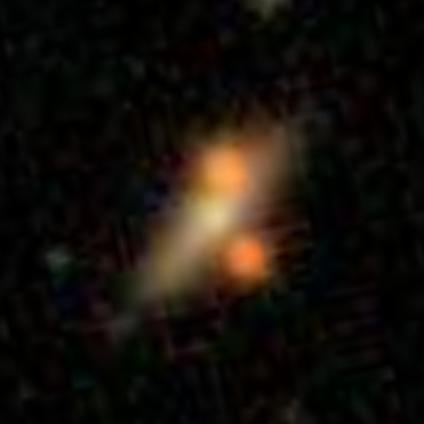

In [16]:
Image.open(f'../raw_data/images_test_rev1/{image_jpg}')

In [17]:
df_X_y[df_X_y['image']==image_jpg]


,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,...,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6,image
42000,0.792308,0.13237,0.075321,0.0,0.13237,0.0,0.13237,0.0,0.13237,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,569489.jpg


In [30]:
df_X_y_noimage = df_X_y.drop(columns=['image'])
pd.DataFrame(predict, columns=list(df_X_y_noimage.columns))
#list(df_X_y_noimage.columns)

,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,0.504588,0.584712,0.262138,0.108997,0.334854,0.000539,0.183565,0.208301,0.274276,-0.10087,...,0.031748,0.144601,-0.161665,0.276021,0.138829,0.333487,0.091682,-0.208109,-0.122275,0.005705


In [22]:
evaluation = cnn_model.evaluate(datagenerator_test)

3/3 [==============================] - 18s 6s/step - loss: 0.0638 - mse: 0.0638


In [23]:
np.sqrt(evaluation[0])

0.25263669928575344